- 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
- 구해진 수익률의 표준편차 계산
- 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
- 나머지 투자 비중 = 현금 보유
- 목표 1% 4.3%/-10.3%
- 목표 2% 5.5%/-24.1%
- 목표 3% 6.3%/-37.6%
- 목표 4% 7.1%/-49.2%
- 목표 5% 7.3%/-59.8%
- 코스피 8.9%/-73.1%

In [1]:
from settings import * 

In [2]:
kospi = fdr.DataReader('KS11')[['Close']]

In [3]:
kospi

,Close
Date,
1981-05-01,123.600
1981-05-02,123.500
1981-05-04,120.600
1981-05-06,120.700
1981-05-07,119.300
...,...
2022-02-17,2744.090
2022-02-18,2744.520
2022-02-21,2743.800


In [4]:
s = '1985-1-30'
e = '2017-6-30'
# e = '2022-02-23'
start = '1986-1-31'

In [5]:
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [6]:
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


In [7]:
# - 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
# - 구해진 수익률의 표준편차 계산
# - 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
# - 나머지 투자 비중 = 현금 보유

# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVol(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=6, lag=pd.DateOffset(days=0), cash='현금'):
        super(WeighTargetVol, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.lag = lag
        self.cash = cash

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        
        t0 = target.now - self.lag
        selected.remove(self.cash)

        start = t0 - pd.DateOffset(months=self.lookback)
        prc = target.universe.loc[start:t0, selected]

        # 월별 수익률의 변동성
        mret = prc.resample('M').last().pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률
        if std.values[0] > self.targetvol:
            weights = pd.Series(self.targetvol/std, index=selected)
        else:
            print("@@@ 몰빵!!!")
            weights = pd.Series(1.0, index=selected)
        weights[self.cash] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [8]:
def strategy_targetvol(name, data, start, targetvol=0.01, months=12, lag=pd.DateOffset(days=0), cash='현금'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=True), # 월말
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVol(targetvol, months, lag, cash),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [9]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'1986-01-30'

In [10]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
r = bt.run(bt목표1)

1986-01-31 00:00:00 목표1% KOSPI:0.295 현금:0.705 
1986-02-28 00:00:00 목표1% KOSPI:0.257 현금:0.743 
1986-03-31 00:00:00 목표1% KOSPI:0.199 현금:0.801 
1986-04-30 00:00:00 목표1% KOSPI:0.207 현금:0.793 
1986-05-31 00:00:00 목표1% KOSPI:0.182 현금:0.818 
1986-06-30 00:00:00 목표1% KOSPI:0.182 현금:0.818 
1986-07-31 00:00:00 목표1% KOSPI:0.178 현금:0.822 
1986-08-30 00:00:00 목표1% KOSPI:0.168 현금:0.832 
1986-09-30 00:00:00 목표1% KOSPI:0.153 현금:0.847 
1986-10-31 00:00:00 목표1% KOSPI:0.140 현금:0.860 
1986-11-29 00:00:00 목표1% KOSPI:0.135 현금:0.865 
1986-12-26 00:00:00 목표1% KOSPI:0.136 현금:0.864 
1987-01-31 00:00:00 목표1% KOSPI:0.133 현금:0.867 
1987-02-28 00:00:00 목표1% KOSPI:0.134 현금:0.866 
1987-03-31 00:00:00 목표1% KOSPI:0.119 현금:0.881 
1987-04-30 00:00:00 목표1% KOSPI:0.102 현금:0.898 
1987-05-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-06-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-07-31 00:00:00 목표1% KOSPI:0.100 현금:0.900 
1987-08-31 00:00:00 목표1% KOSPI:0.101 현금:0.899 
1987-09-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-10-31 00

In [11]:
r.set_date_range(start, e)
r.display()

Stat                 목표1%
-------------------  ----------
Start                1986-01-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         280.08%
Daily Sharpe         1.14
Daily Sortino        1.91
CAGR                 4.34%
Max Drawdown         -11.01%
Calmar Ratio         0.39

MTD                  0.99%
3m                   6.51%
6m                   10.92%
YTD                  10.92%
1Y                   13.12%
3Y (ann.)            5.31%
5Y (ann.)            4.29%
10Y (ann.)           3.51%
Since Incep. (ann.)  4.34%

Daily Sharpe         1.14
Daily Sortino        1.91
Daily Mean (ann.)    4.09%
Daily Vol (ann.)     3.60%
Daily Skew           -0.15
Daily Kurt           3.01
Best Day             1.46%
Worst Day            -1.46%

Monthly Sharpe       1.08
Monthly Sortino      2.27
Monthly Mean (ann.)  4.34%
Monthly Vol (ann.)   4.02%
Monthly Skew         0.14
Monthly Kurt         2.48
Best Month           5.67%
Worst Month          -5.10%

Yearly Sha

In [12]:
r.prices.resample('M').last().to_drawdown_series().min()

목표1%   -0.102
dtype: float64

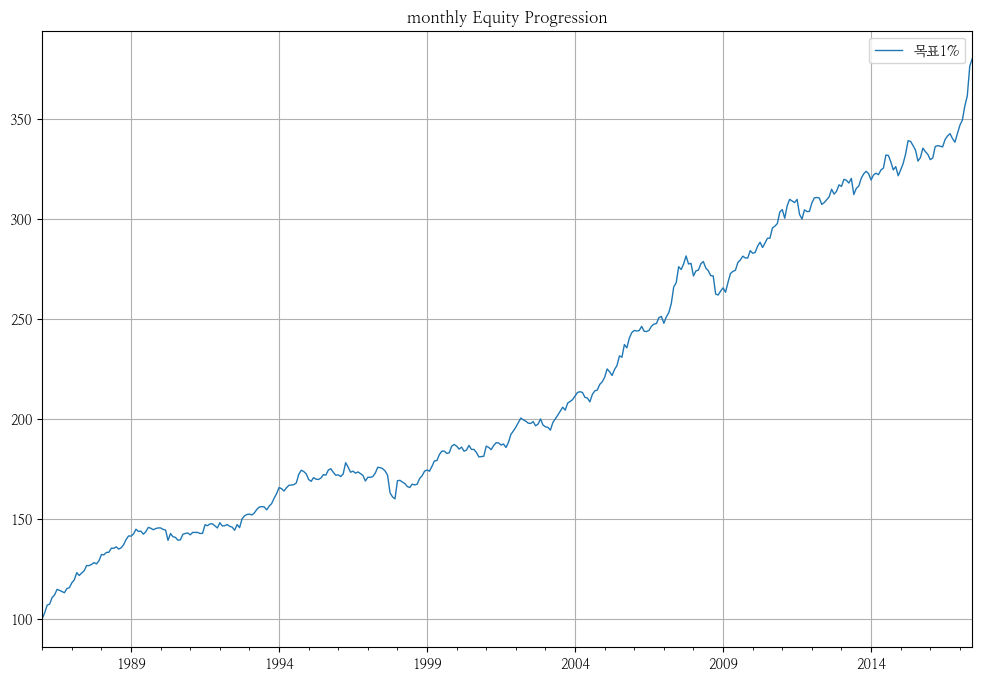

In [13]:
r.plot(freq='M', figsize=(12, 8));

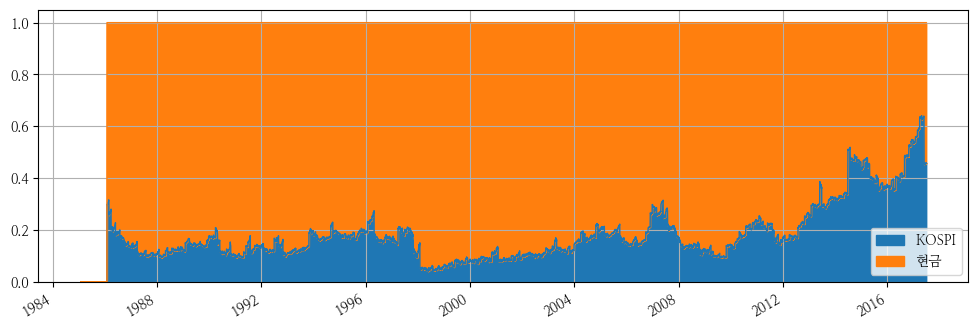

In [14]:
r.get_security_weights().plot.area(figsize=(12,4));

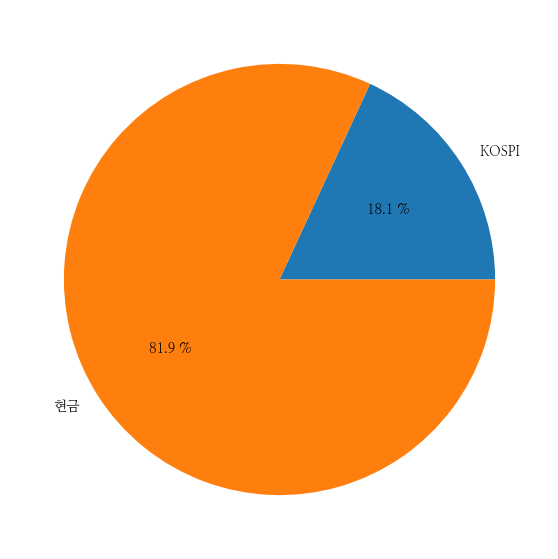

In [15]:
r.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(7,7));

In [16]:
bt_kospi = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
r_kospi = bt.run(bt_kospi)

1985-01-30 00:00:00


In [17]:
r_all = bt.run(bt_kospi, bt목표1)
r_all.set_date_range(start)
r_all.display()

Stat                 KOSPI       목표1%
-------------------  ----------  ----------
Start                1986-01-31  1986-01-31
End                  2017-06-30  2017-06-30
Risk-free rate       0.00%       0.00%

Total Return         1390.95%    280.08%
Daily Sharpe         0.45        1.14
Daily Sortino        0.74        1.91
CAGR                 8.98%       4.34%
Max Drawdown         -75.41%     -11.01%
Calmar Ratio         0.12        0.39

MTD                  1.89%       0.99%
3m                   10.49%      6.51%
6m                   18.03%      10.92%
YTD                  18.03%      10.92%
1Y                   21.39%      13.12%
3Y (ann.)            6.10%       5.31%
5Y (ann.)            5.26%       4.29%
10Y (ann.)           3.05%       3.51%
Since Incep. (ann.)  8.98%       4.34%

Daily Sharpe         0.45        1.14
Daily Sortino        0.74        1.91
Daily Mean (ann.)    11.26%      4.09%
Daily Vol (ann.)     24.93%      3.60%
Daily Skew           -0.06       -0.15
Daily 

       CAGR
KOSPI 8.983
목표1%  4.342
          MDD
KOSPI -75.412
목표1%  -11.007


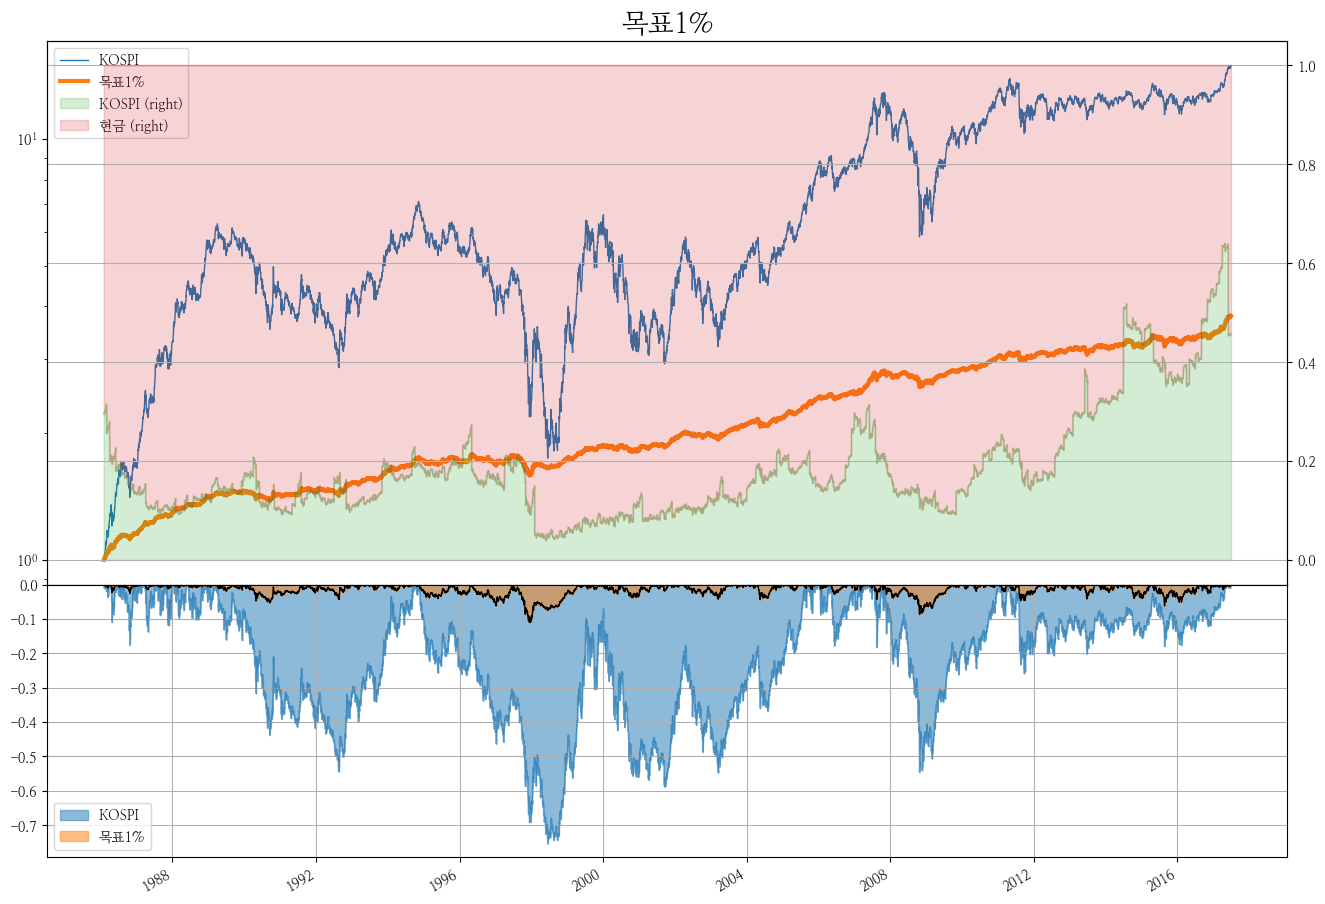

In [18]:
plot_assets(r_all, start, e, "목표1%")

In [19]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
bt목표2 = strategy_targetvol("목표2%", data_daily, after_date, targetvol=0.02)
bt목표3 = strategy_targetvol("목표3%", data_daily, after_date, targetvol=0.03)
bt목표4 = strategy_targetvol("목표4%", data_daily, after_date, targetvol=0.04)
bt목표5 = strategy_targetvol("목표5%", data_daily, after_date, targetvol=0.05)
r_all = bt.run(bt목표1,bt목표2,bt목표3,bt목표4,bt목표5,bt_kospi)

1986-01-31 00:00:00 목표1% KOSPI:0.295 현금:0.705 
1986-02-28 00:00:00 목표1% KOSPI:0.257 현금:0.743 
1986-03-31 00:00:00 목표1% KOSPI:0.199 현금:0.801 
1986-04-30 00:00:00 목표1% KOSPI:0.207 현금:0.793 
1986-05-31 00:00:00 목표1% KOSPI:0.182 현금:0.818 
1986-06-30 00:00:00 목표1% KOSPI:0.182 현금:0.818 
1986-07-31 00:00:00 목표1% KOSPI:0.178 현금:0.822 
1986-08-30 00:00:00 목표1% KOSPI:0.168 현금:0.832 
1986-09-30 00:00:00 목표1% KOSPI:0.153 현금:0.847 
1986-10-31 00:00:00 목표1% KOSPI:0.140 현금:0.860 
1986-11-29 00:00:00 목표1% KOSPI:0.135 현금:0.865 
1986-12-26 00:00:00 목표1% KOSPI:0.136 현금:0.864 
1987-01-31 00:00:00 목표1% KOSPI:0.133 현금:0.867 
1987-02-28 00:00:00 목표1% KOSPI:0.134 현금:0.866 
1987-03-31 00:00:00 목표1% KOSPI:0.119 현금:0.881 
1987-04-30 00:00:00 목표1% KOSPI:0.102 현금:0.898 
1987-05-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-06-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-07-31 00:00:00 목표1% KOSPI:0.100 현금:0.900 
1987-08-31 00:00:00 목표1% KOSPI:0.101 현금:0.899 
1987-09-30 00:00:00 목표1% KOSPI:0.105 현금:0.895 
1987-10-31 00

In [20]:
r_all.set_date_range(start)
r_all.display()

Stat                 목표1%      목표2%      목표3%      목표4%      목표5%      KOSPI
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                1986-01-31  1986-01-31  1986-01-31  1986-01-31  1986-01-31  1986-01-31
End                  2017-06-30  2017-06-30  2017-06-30  2017-06-30  2017-06-30  2017-06-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         280.08%     434.21%     592.29%     750.88%     793.38%     1390.95%
Daily Sharpe         1.14        0.74        0.61        0.55        0.49        0.45
Daily Sortino        1.91        1.22        1.01        0.90        0.80        0.74
CAGR                 4.34%       5.48%       6.35%       7.05%       7.22%       8.98%
Max Drawdown         -11.01%     -25.73%     -39.52%     -51.20%     -61.81%     -75.41%
Calmar Ratio         0.39        0.21        0.16        0.14        0.12        0.12

MTD                  0.99%       1

In [21]:
r_all.prices.resample('M').last().to_drawdown_series().min()*100

목표1%    -10.172
목표2%    -23.736
목표3%    -37.120
목표4%    -48.612
목표5%    -59.268
KOSPI   -73.058
dtype: float64

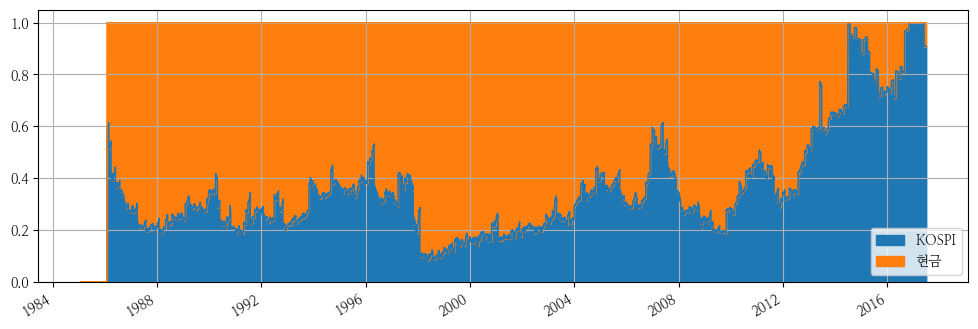

In [22]:
r_all.get_security_weights('목표2%').plot.area(figsize=(12,4));

<AxesSubplot:title={'center':'monthly Equity Progression'}>

Text(0.5, 1.0, '그림 3-27 변동성 목표 전략(코스피)')

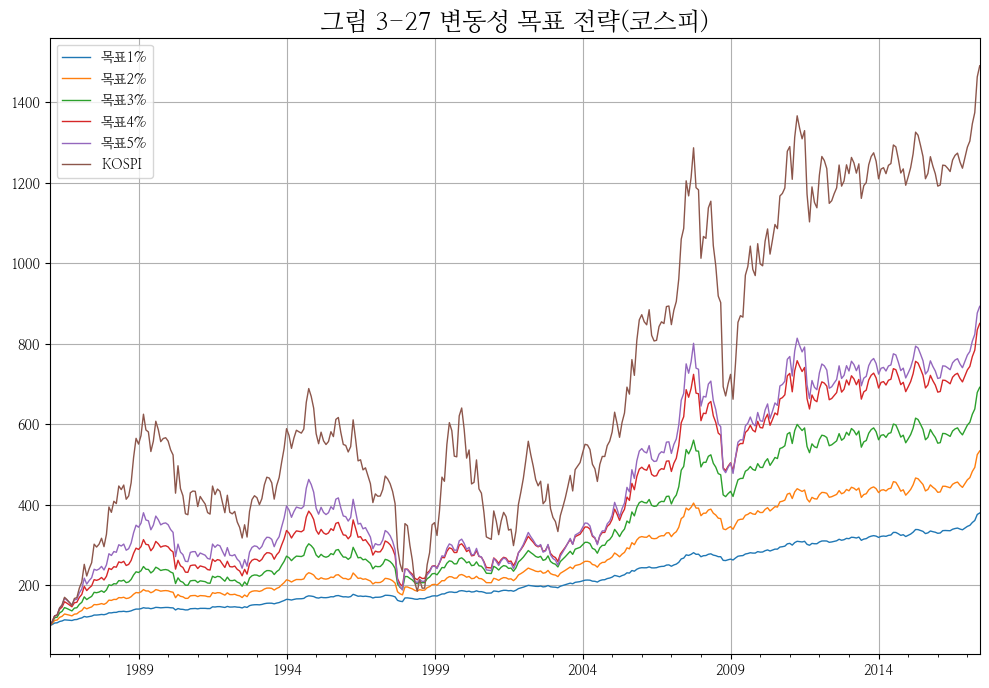

In [23]:
r_all.plot(freq='M', figsize=(12, 8));
plt.title("그림 3-27 변동성 목표 전략(코스피)", fontsize=18)

       CAGR
목표1%  4.342
목표2%  5.479
목표3%  6.353
목표4%  7.054
목표5%  7.220
KOSPI 8.983
          MDD
목표1%  -11.007
목표2%  -25.727
목표3%  -39.522
목표4%  -51.196
목표5%  -61.808
KOSPI -75.412


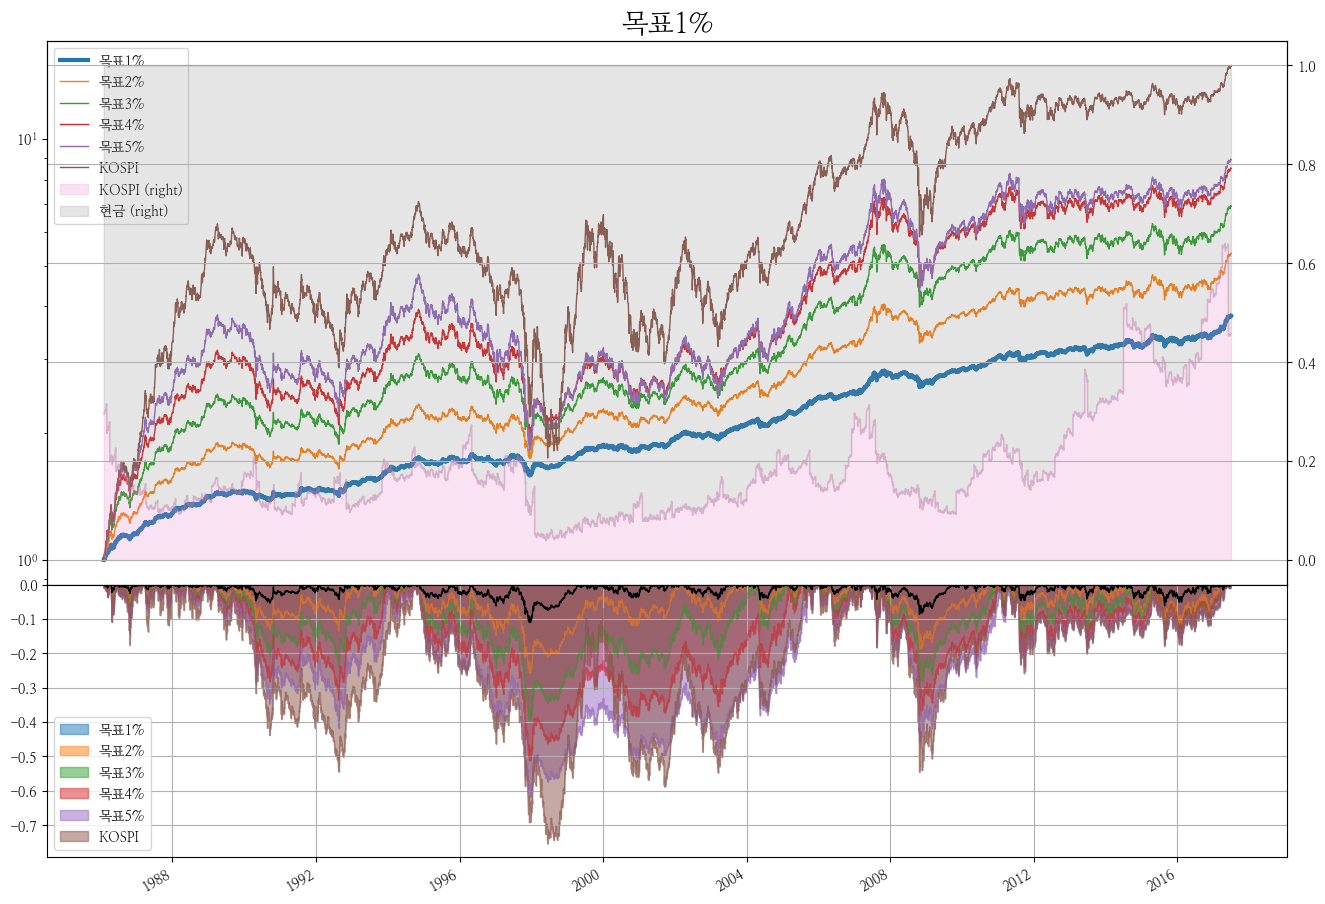

In [24]:
plot_assets(r_all, start, e, "목표1%")